In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
from jax.experimental.sparse.transform import method

from pytensor.graph import Apply, Op
from scipy.optimize import approx_fprime

In [2]:
RANDOM_SEED = 42

In [4]:
import numpy as np
import pytensor.tensor as pt
from pytensor.graph.op import Op, Apply
import pymc as pm
import pandas as pd

# Define interpolate function
def interpolate(x0, y0, x):
    x = np.array(x)
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d
    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

# Load data and ensure it's a NumPy array
data = pd.read_csv('grids_example_1.csv', header=None).values
param_min = data[0, :].min()
param_max = data[0, :].max()

# Function to compute log-likelihood    
def my_loglike(x, data):
    x_vals = data[0, :]
    loglike_vals = data[1, :]
    return interpolate(x_vals, loglike_vals, x)

# Define custom PyTensor operation
class LogLike(Op):
    def make_node(self, x, data):
        x = pt.as_tensor_variable(x)  # Ensure x is a tensor
        data = pt.as_tensor_variable(data)  # Ensure data is a tensor
        inputs = [x, data]
        outputs = [pt.TensorType(dtype="float64", broadcastable=(False,))()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        x, data = inputs
        x_vals = data[0, :]
        loglike_vals = data[1, :]
        loglike_eval = interpolate(x_vals, loglike_vals, x)
        outputs[0][0] = np.array(loglike_eval)

# Initialize operation
loglike_op = LogLike()

# PyMC model without observed data
with pm.Model() as no_grad_model:
    # Define prior for x
    x = pm.Uniform("x", lower=param_min, upper=param_max, shape=1)

    # Add a custom potential for the likelihood
    pm.Potential("likelihood", loglike_op(x, data))

    # Sample posterior
    idata = pm.sample(
        200000, 
        tune=5000,
        chains=8,
    )

KeyboardInterrupt: 

In [5]:
import numpy as np
import pytensor.tensor as pt
from pytensor.graph.op import Op, Apply
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt

# Define interpolate function
def interpolate(x0, y0, x):
    x = np.array(x)
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d
    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

# Load data and ensure it's a NumPy array
data = pd.read_csv('grids_example_1.csv', header=None).values
param_min = data[0, :].min()
param_max = data[0, :].max()

In [ ]:
# plot the data
plt.plot(data[0, :], data[1, :], 'o')

plt.show()

### **1. Interpolation of Log-Likelihoods**
For each outcome \( j \), we interpolate the log-likelihood for each component \( k \):

$$\hat{\ell}_{j,k} = \text{interpolate}(x_{\text{grid},j}, \ell_{\text{grid},j}, \beta_{j,k})$$


$$\ell_k = \sum_{j=1}^{N_{\text{outcomes}}} \hat{\ell}_{j,k}$$

$$\ell_{\text{final}} = \log \sum_{k=1}^{N_{\text{components}}} \pi_k e^{\ell_k}$$


In [7]:
import numpy as np
import pandas as pd
import pytensor.tensor as pt
from pytensor.graph.op import Op, Apply
import pymc as pm

# Load profile likelihood data
data = pd.read_csv("profileLikelihoods_NCs_long.csv")

# Define interpolation function
def interpolate(x0, y0, x):
    x = np.array(x)
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d
    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

# Define custom likelihood function
class LogLike(Op):
    def make_node(self, β, num_outcomes, source_data):
        β = pt.as_tensor(β)  # Ensure scalar
        num_outcomes = pt.as_tensor(int(num_outcomes))  # Ensure scalar integer
        source_data = pt.as_tensor(np.asarray(source_data))  # Ensure NumPy array

        # The output must be a single scalar
        outputs = [pt.dscalar()]
        return Apply(self, [β, num_outcomes, source_data], outputs)

    def perform(self, node, inputs, outputs):
        β, num_outcomes, source_data = inputs
        num_outcomes = int(num_outcomes)  # Ensure integer

        # Compute total log-likelihood (scalar β)
        total_log_likelihood = 0.0

        for j in range(num_outcomes):
            # Extract outcome-specific x_vals and loglike_vals
            outcome_data = source_data[source_data[:, 2] == (j+1)]  # Filter by outcome index
            
            if outcome_data.shape[0] == 0:
                raise ValueError(f"No data found for outcome {j+1} in source_data!")

            x_vals = outcome_data[:, 0]  # Parameter grid points
            loglike_vals = outcome_data[:, 1]  # Log-likelihood values

            # Interpolate the log-likelihood for β
            loglike_j = interpolate(x_vals, loglike_vals, β)

            # Sum in log-space
            total_log_likelihood += loglike_j

        # Ensure the output is a scalar
        outputs[0][0] = np.array(total_log_likelihood)

# Initialize the custom operation
loglike_op = LogLike()

# Simulated test case for source 1
n_outcomes_test = int(data["outcome"].nunique())  # Ensure integer
n_components = 3  # Assume 3 components for illustration

np.random.seed(42)
β_test = np.random.uniform(low=-1, high=-0.5)  # Simulated β values
num_outcomes_test = int(data[data["source"] == 1]["outcome"].nunique())  # Ensure integer
source_1_data = data[data["source"] == 1][["point", "value", "outcome"]].values  # Include outcome column
weights_test = np.full(n_components, 1 / n_components)  # Equal mixture weights


test_out = loglike_op(β_test, num_outcomes_test, source_1_data)
print("Evaluated Test Likelihood Output:", test_out.eval())



Evaluated Test Likelihood Output: -30.351530816420613


# Likelihood with gradient

In [5]:
def my_loglike(β, num_outcomes, source_data):
    # We fail explicitly if inputs are not numerical types for the sake of this tutorial
    # As defined, my_loglike would actually work fine with PyTensor variables!
    for param in (β, num_outcomes, source_data):
        if not isinstance(param, (float, int, np.ndarray)):
            raise TypeError(f"Invalid input type to loglike: {type(param)}")
            β, num_outcomes, source_data = inputs
    num_outcomes = int(num_outcomes)  # Ensure integer

    # Compute total log-likelihood (scalar β)
    total_log_likelihood = 0.0

    for j in range(num_outcomes):
        # Extract outcome-specific x_vals and loglike_vals
        outcome_data = source_data[source_data[:, 2] == (j+1)]  # Filter by outcome index

        if outcome_data.shape[0] == 0:
            raise ValueError(f"No data found for outcome {j+1} in source_data!")

        x_vals = outcome_data[:, 0]  # Parameter grid points
        loglike_vals = outcome_data[:, 1]  # Log-likelihood values

        # Interpolate the log-likelihood for β
        loglike_j = interpolate(x_vals, loglike_vals, β)

        # Sum in log-space
        total_log_likelihood += loglike_j

    # Ensure the output is a scalar
    return np.array(total_log_likelihood)

In [14]:
my_loglike(β_test, num_outcomes_test, source_1_data)

array(-30.35153082)

In [10]:
def finite_differences_loglike(β, num_outcomes, source_data, eps=1e-5):
    β = np.atleast_1d(β)  # Ensure `β` is a 1D array
    
    def inner_func(β):
        return np.array([my_loglike(β[0], num_outcomes, source_data)])  # Ensure array output

    grad_wrt_β = approx_fprime(β, inner_func, [eps])  # Compute gradient as array
    return grad_wrt_β[0]  # Return the first element as scalar

In [11]:
# Define interpolation function
def interpolate(x0, y0, x):
    x = np.array(x)

    if x0.size == 0 or y0.size == 0:
        raise ValueError("Empty data passed to interpolation!")

    idx = np.searchsorted(x0, x) - 1  # Ensure index is within bounds
    idx = np.clip(idx, 0, len(x0) - 2)  # Clip to avoid out-of-range errors

    dl = x - x0[idx]
    dr = x0[idx + 1] - x
    d = dl + dr

    # Prevent division by zero
    wl = np.where(d != 0, dr / d, 0.5)
    return wl * y0[idx] + (1 - wl) * y0[idx + 1]

# Define `LogLike` with gradients
class LogLike(Op):
    def make_node(self, β, num_outcomes, source_data):
        β = pt.as_tensor(β)  # Ensure scalar
        num_outcomes = pt.as_tensor(num_outcomes, dtype="int32")  # Ensure scalar integer
        source_data = pt.as_tensor(source_data, dtype=np.float64)  # Ensure NumPy array

        # The output must be a single scalar
        outputs = [pt.dscalar()]
        return Apply(self, [β, num_outcomes, source_data], outputs)

    def perform(self, node, inputs, outputs):
        β, num_outcomes, source_data = inputs
        num_outcomes = int(num_outcomes)  # Ensure integer

        # Compute total log-likelihood (scalar β)
        total_log_likelihood = 0.0

        for j in range(num_outcomes):
            # Extract outcome-specific x_vals and loglike_vals
            outcome_data = source_data[source_data[:, 2] == (j+1)]  # Filter by outcome index

            if outcome_data.shape[0] == 0:
                raise ValueError(f"No data found for outcome {j+1} in source_data!")

            x_vals = outcome_data[:, 0]  # Parameter grid points
            loglike_vals = outcome_data[:, 1]  # Log-likelihood values

            # Interpolate the log-likelihood for β
            loglike_j = interpolate(x_vals, loglike_vals, β)

            # Sum in log-space
            total_log_likelihood += loglike_j

        # Ensure the output is a scalar
        outputs[0][0] = np.array(total_log_likelihood)

    def grad(self, inputs: list[pt.TensorVariable], g: list[pt.TensorVariable])-> list[pt.TensorVariable]:
        β, num_outcomes, source_data = inputs

        # Compute gradient using finite differences
        grad_β = loglikegrad_op(β, num_outcomes, source_data)

        [out_grad] = g
        return [
            pt.sum(out_grad * grad_β),  # Gradient w.r.t. β
            pytensor.gradient.grad_not_implemented(self, 1, num_outcomes),  # No gradient w.r.t. num_outcomes
            pytensor.gradient.grad_not_implemented(self, 2, source_data),   # No gradient w.r.t. source_data
        ]

# Define the gradient computation using finite differences
class LogLikeGrad(Op):
    def make_node(self, β, num_outcomes, source_data):
        β = pt.as_tensor(β)
        num_outcomes = pt.as_tensor(num_outcomes, dtype="int32") 
        source_data = pt.as_tensor(source_data, dtype=np.float64) 

        inputs = [β, num_outcomes, source_data]
        outputs = [β.type()]  # Output shape matches β

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        β, num_outcomes, source_data = inputs
        grad_β = finite_differences_loglike(β, num_outcomes, source_data)
        outputs[0][0] = np.array(grad_β)

# Initialize the Ops
loglike_op = LogLike()
loglikegrad_op = LogLikeGrad()

In [8]:
import numpy as np
import pytensor.tensor as pt

# Set random seed
np.random.seed(42)

# Generate test data for β
β = pt.scalar("β")
num_outcomes_test = int(data[data["source"] == 1]["outcome"].nunique())  # Ensure integer
source_1_data = data[data["source"] == 1][["point", "value", "outcome"]].astype(float).values  # Convert to float

# Compute likelihood
loglike_output = loglike_op(β, num_outcomes_test, source_1_data)
eval_out = loglike_output.eval({β: -0.5})
print(eval_out)

-27.66955915202564


In [9]:
grad_b = pytensor.grad(loglike_output.sum(), wrt=[β])
pytensor.dprint(grad_b, print_type=True)


Sum{axes=None} [id A] <Scalar(float64, shape=())>
 └─ Mul [id B] <Scalar(float64, shape=())>
    ├─ Second [id C] <Scalar(float64, shape=())>
    │  ├─ LogLike [id D] <Scalar(float64, shape=())>
    │  │  ├─ β [id E] <Scalar(float64, shape=())>
    │  │  ├─ 6 [id F] <Scalar(int32, shape=())>
    │  │  └─ [[ -2.3025 ... 6.     ]] [id G] <Matrix(float64, shape=(66, 3))>
    │  └─ DimShuffle{order=[]} [id H] <Scalar(float64, shape=())>
    │     └─ Second [id I] <Scalar(float64, shape=())>
    │        ├─ Sum{axes=None} [id J] <Scalar(float64, shape=())>
    │        │  └─ LogLike [id D] <Scalar(float64, shape=())>
    │        │     └─ ···
    │        └─ 1.0 [id K] <Scalar(float64, shape=())>
    └─ LogLikeGrad [id L] <Scalar(float64, shape=())>
       ├─ β [id E] <Scalar(float64, shape=())>
       ├─ 6 [id F] <Scalar(int32, shape=())>
       └─ [[ -2.3025 ... 6.     ]] [id G] <Matrix(float64, shape=(66, 3))>


In [8]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

def reparameterize(pi):
    return pi / pi.sum()

def hierarchical_beta(alpha0, beta, nsources, k):
    """Hierarchical Beta distribution for multiple sources."""
    pi_tilt_sources = []
    
    for s in range(nsources):
        beta_params = [(alpha0 * beta[k], alpha0 * (1 - pm.math.sum(beta[:k + 1]))) for k in range(k)]
        pi_tilt = pm.Beta(f'pi_tilt_{s}', 
                          alpha=[b[0] for b in beta_params], 
                          beta=[b[1] for b in beta_params], 
                          dims="component")
        pi_tilt_sources.append(pi_tilt)
    
    #return pm.math.stack(pi_tilt_sources, axis=0)
    return pi_tilt_sources

In [11]:
import pymc as pm
import numpy as np
import pandas as pd

# Load profile likelihood data
data = pd.read_csv("profileLikelihoods_NCs_long.csv")

# Constants
N_sources = data["source"].nunique()  # Number of sources
k = 5  # Number of mixture components

# Precompute source data and number of outcomes
source_data_dict = {}
num_outcomes_dict = {}

N_sources = 8

for s in range(1, N_sources + 1):  # Ensure correct indexing
    source_data_dict[s] = data[data["source"] == s][["point", "value", "outcome"]].astype(float).values
    num_outcomes_dict[s] = int(data[data["source"] == s]["outcome"].nunique())

# PyMC Model
with pm.Model(coords={"component": np.arange(k), "n_source": np.arange(N_sources)}) as HDP_model:

    # Priors for hierarchical Dirichlet process weights
    gamma = pm.Gamma("gamma", 1.0, 5.0)
    alpha0 = pm.Gamma("alpha0", 1.0, 5.0)
    
    # Stick-breaking process for mixture weights
    beta_tilt = pm.Beta("beta_tilt", 1.0, gamma, dims="component")
    beta = pm.Deterministic("beta", stick_breaking(beta_tilt), dims="component")
    π_tilt = hierarchical_beta(alpha0, beta, nsources=N_sources, k=k)

    π_norms = []
    for s in range(N_sources):
        π = pm.Deterministic(f"π_{s}", stick_breaking(π_tilt[s]), dims="component")
        π_norms.append(pm.Deterministic(f"π_norm_{s}", reparameterize(π), dims=["component"]))

    # Mixture component parameters
    μ = pm.Normal(
        "μ",
        mu=data["point"].mean(),  # Use the mean of the profile likelihood grid points
        sigma=10,
        shape=k,
        transform=pm.distributions.transforms.ordered,  # Ensure μ is ordered
        initval=np.linspace(-1, 1, k),  # Reasonable ordered starting values
    )

    σ = pm.HalfNormal("σ", sigma=10, shape=k)

    # Likelihood for each source
    for s in range(1, N_sources + 1):  # Ensure correct indexing
        # Draw β from the mixture model
        β = pm.NormalMixture(f'β_{s}', w=π_norms[s-1], mu=μ, sigma=σ)
        βt = pm.Deterministic(f"β_clipped_{s}", pm.math.clip(β, source_data_dict[s][:, 0].min(), source_data_dict[s][:, 0].max()))
        #βt = pm.Truncated(f"β_truncated_{s}", β , lower=source_data[:, 0].min(), upper=source_data[:, 0].max())
        # Use precomputed values
        num_outcomes = num_outcomes_dict[s]
        source_data = source_data_dict[s]

        likelihood = pm.Potential(f"loglike_{s}", loglike_op(βt, num_outcomes, source_data))

    # Sampling
    trace = pm.sample(
        tune=5000,
        draws=20000,
        init="advi",
        #step=pm.Metropolis(),  # Use Metropolis for non-differentiable likelihood
        random_seed=42,
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [gamma, alpha0, beta_tilt, pi_tilt_0, pi_tilt_1, pi_tilt_2, pi_tilt_3, pi_tilt_4, pi_tilt_5, pi_tilt_6, pi_tilt_7, μ, σ]
>CompoundStep
>>Slice: [β_1]
>>Slice: [β_2]
>>Slice: [β_3]
>>Slice: [β_4]
>>Slice: [β_5]
>>Slice: [β_6]
>>Slice: [β_7]
>>Slice: [β_8]


Output()

Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 50649 seconds.
There were 71058 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha0,0.597,0.300,0.141,1.145,0.013,0.009,435.0,736.0,1.01
beta[0],0.478,0.187,0.072,0.771,0.024,0.017,80.0,55.0,1.05
beta[1],0.181,0.153,0.004,0.487,0.021,0.015,55.0,122.0,1.07
beta[2],0.089,0.083,0.002,0.230,0.006,0.005,144.0,303.0,1.03
beta[3],0.069,0.058,0.002,0.174,0.002,0.002,263.0,257.0,1.02
...,...,...,...,...,...,...,...,...,...
σ[0],1.134,3.286,0.001,6.081,0.556,0.397,54.0,51.0,1.06
σ[1],5.151,5.440,0.009,15.455,0.294,0.208,115.0,44.0,1.03
σ[2],7.514,5.904,0.004,17.974,0.197,0.140,647.0,577.0,1.02
σ[3],7.632,5.872,0.001,18.136,0.174,0.123,390.0,107.0,1.01


In [14]:
import dill 

with open('posterior_samples.pkl', 'wb') as f:
    dill.dump((HDP_model, trace), f)

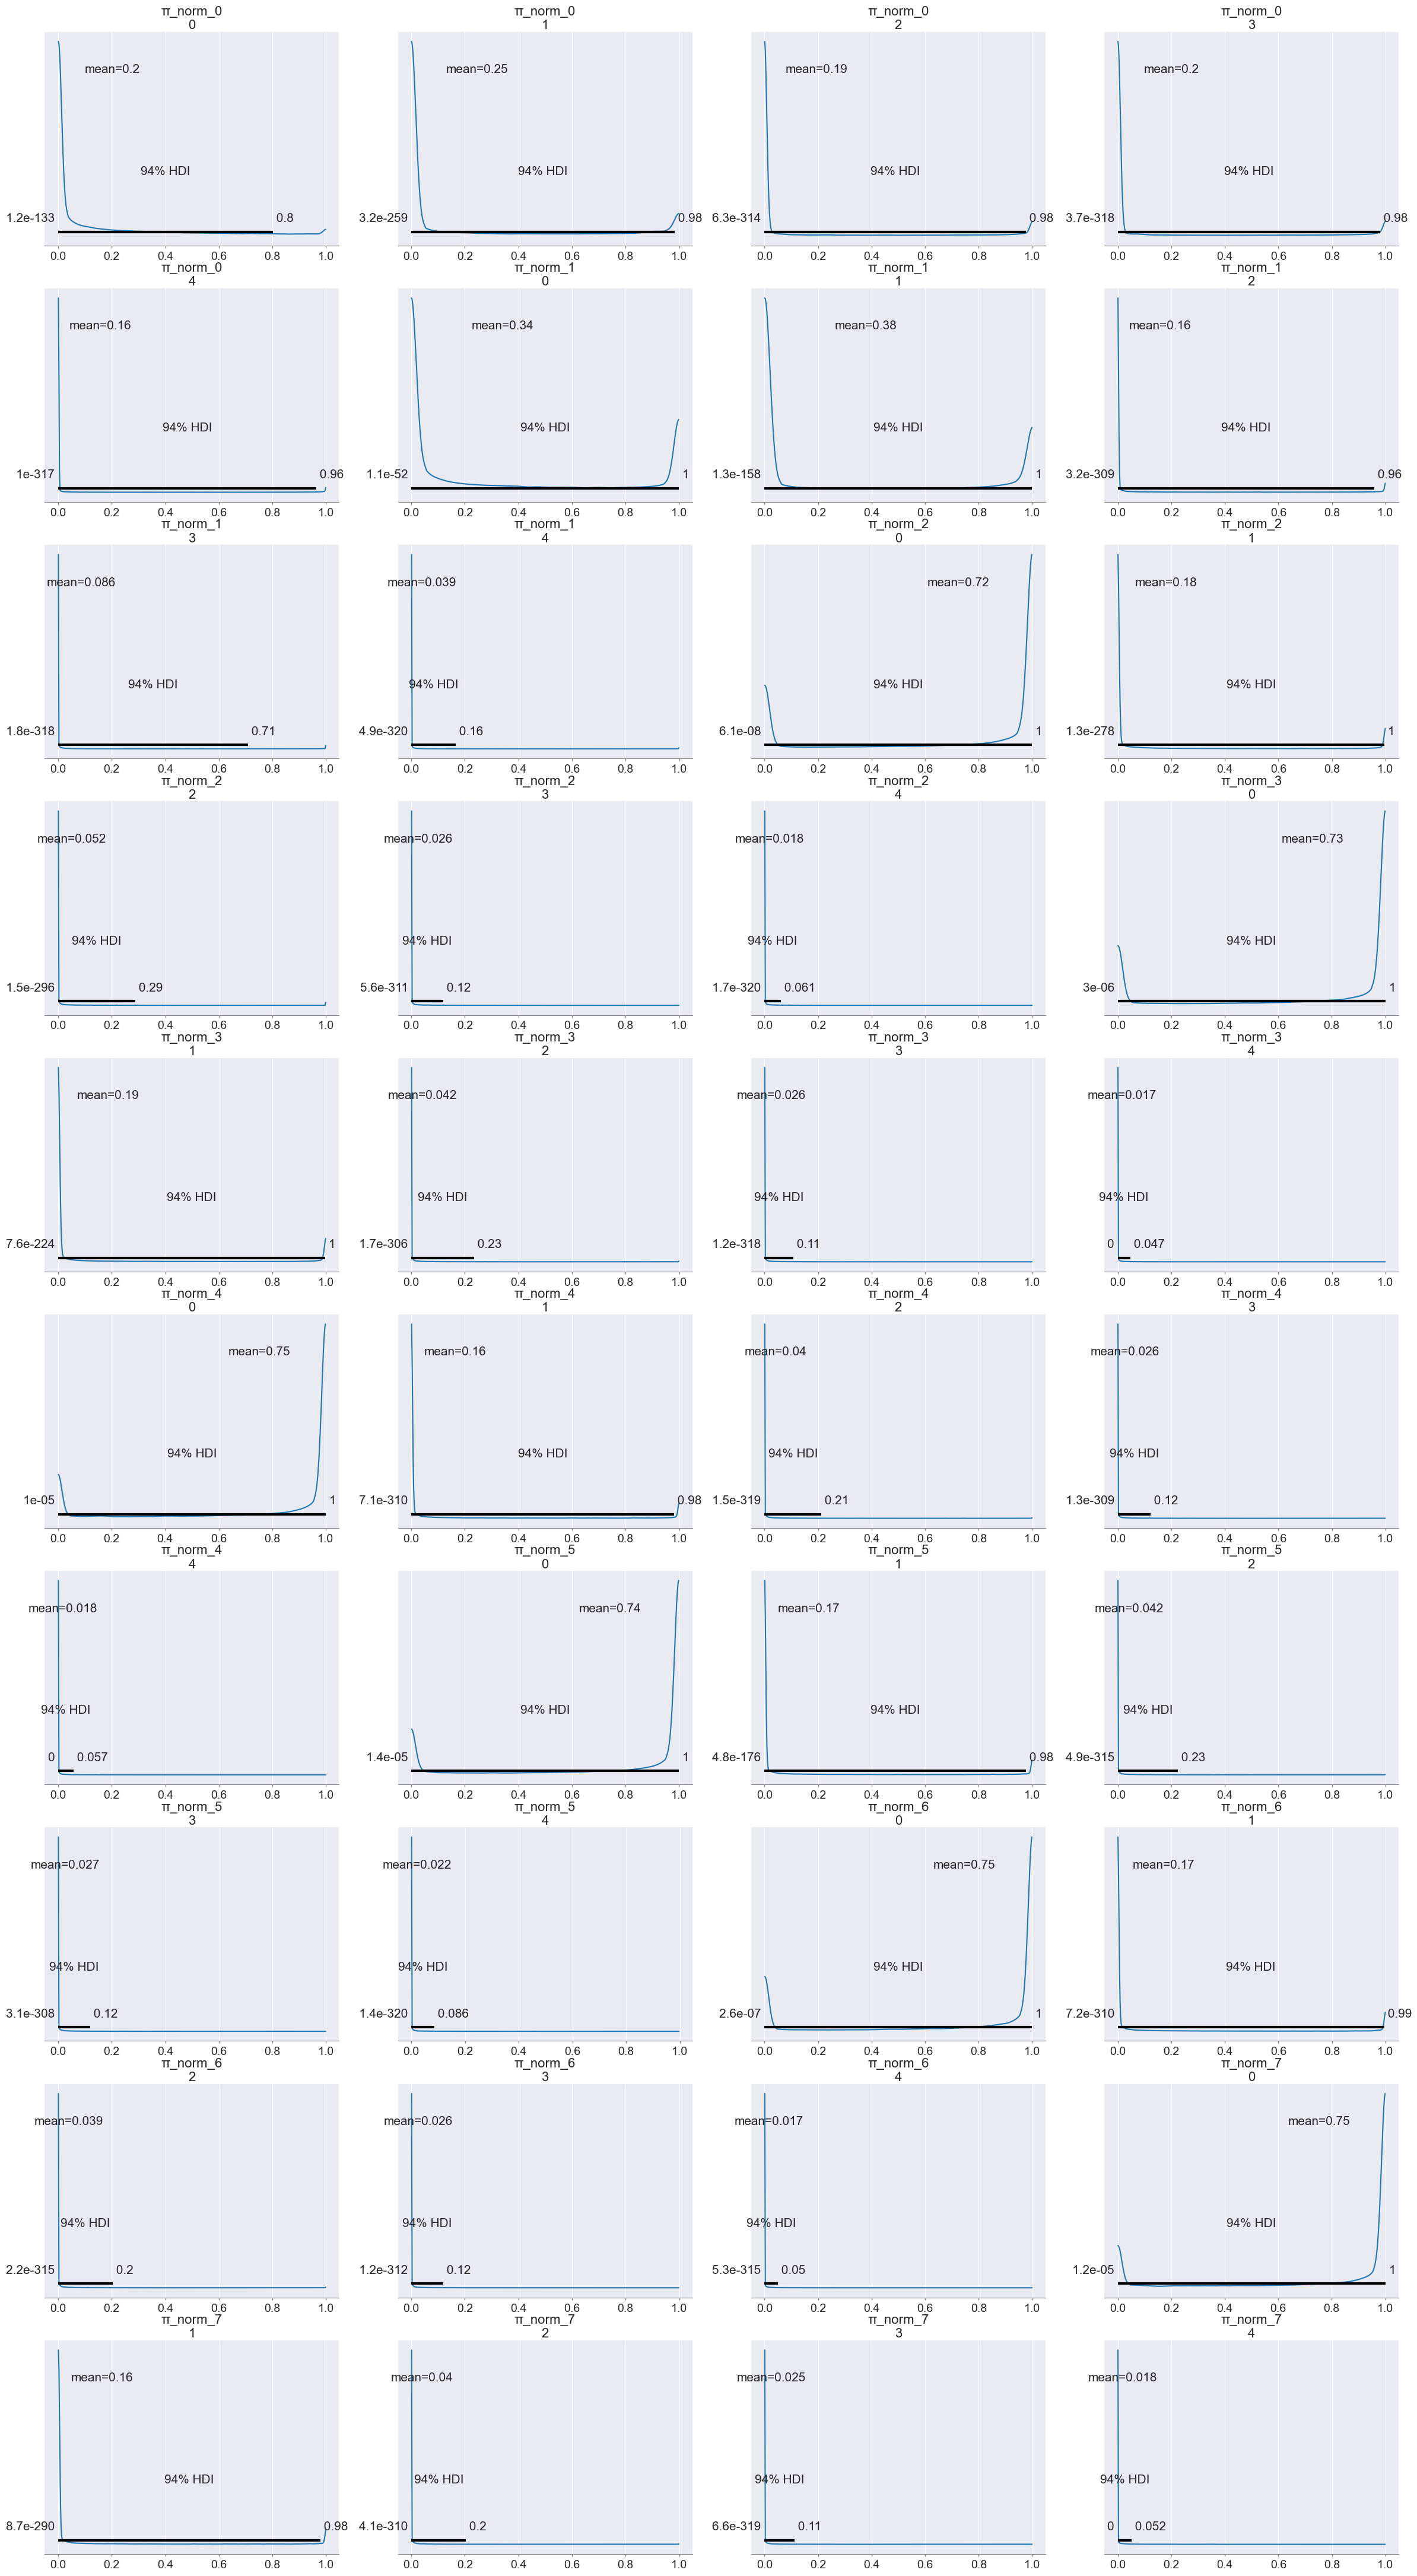

In [26]:
π_norm_name = [f"π_norm_{s}" for s in range(N_sources)]
β_name = [f"β_{s}" for s in range(1, N_sources + 1)]
β_clipped_name = [f"β_clipped_{s}" for s in range(1, N_sources + 1)]
az.plot_posterior(trace, var_names=π_norm_name, kind="kde", bins=20)
plt.show()
